1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

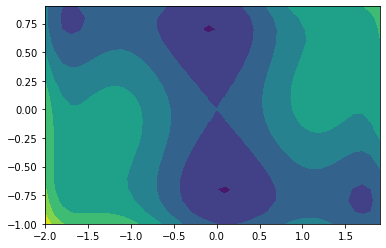

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def f(x):
    return (4 - 2.1*x[0]**2 + (x[0]**4)/3) * x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.arange(-2, +2, 0.1)
y = np.arange(-1, +1, 0.1)

xx, yy = np.meshgrid(x, y, sparse=True)
z = f([xx, yy])

h = plt.contourf(x, y, z)
plt.show()

In [2]:
sol1 = optimize.minimize(f, [-2, -1])
sol2 = optimize.minimize(f, [+2, +1])

In [3]:
# There are two global minima
print(f'Global minimum 1: ({sol1.x[0]}, {sol1.x[1]}) with value: {sol1.fun}')
print(f'Global minimum 2: ({sol2.x[0]}, {sol2.x[1]}) with value: {sol2.fun}')

Global minimum 1: (0.08984183776656297, -0.7126562823479043) with value: -1.0316284534896594
Global minimum 2: (-0.08984185168166231, 0.712656268772178) with value: -1.0316284534896498


In [4]:
# If we use (0, 0) as initial guess we get stuck in a saddle point and we
# don't get the real global minima
sol3 = optimize.minimize(f, [0, 0])
print(sol3)

      fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0, 0.5, 'Temperature')

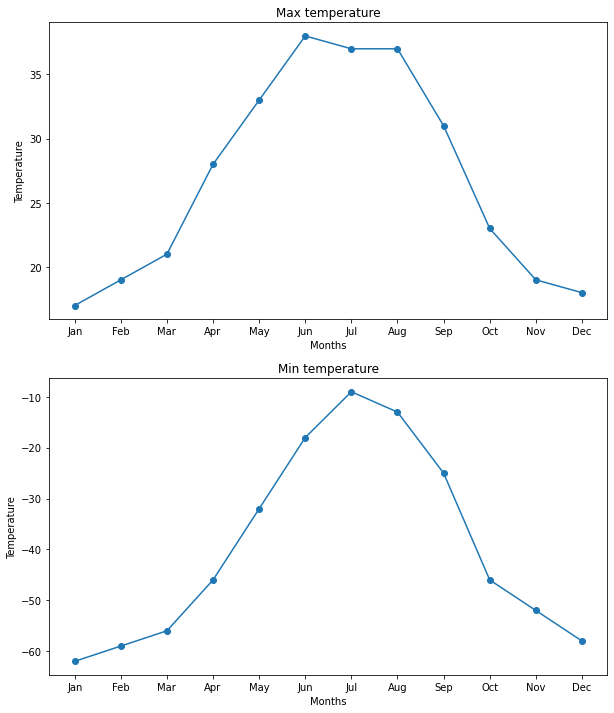

In [5]:
temp_max = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
temp_min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

ax1.plot_date(months, temp_max, xdate=True, linestyle='solid')
ax2.plot_date(months, temp_min, xdate=True, linestyle='solid')

ax1.set_title('Max temperature')
ax1.set_xlabel('Months')
ax1.set_ylabel('Temperature')

ax2.set_title('Min temperature')
ax2.set_xlabel('Months')
ax2.set_ylabel('Temperature')

In [6]:
#def gaussian(x, mu, sig):
#    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def gaussian(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params_max, params_covariance_max = optimize.curve_fit(gaussian, range(12), temp_max, full_output=False)

print('Parameters for max temp')
print('H = %.2f +- %.2f' % (params_max[0], np.sqrt(params_covariance_max[0,0])))
print('A = %.2f +- %.2f' % (params_max[1], np.sqrt(params_covariance_max[1,1])))
print('x0 = %.2f +- %.2f' % (params_max[2], np.sqrt(params_covariance_max[2,2])))
print('Sigma = %.2f +- %.2f\n' % (params_max[3], np.sqrt(params_covariance_max[3,3])))

params_min, params_covariance_min = optimize.curve_fit(gaussian, range(12), temp_min, p0=[1, 1, 5.5, 1], full_output=False)

print('Parameters for min temp')
print('H = %.2f +- %.2f' % (params_min[0], np.sqrt(params_covariance_min[0,0])))
print('A = %.2f +- %.2f' % (params_min[1], np.sqrt(params_covariance_min[1,1])))
print('x0 = %.2f +- %.2f' % (params_min[2], np.sqrt(params_covariance_min[2,2])))
print('Sigma = %.2f +- %.2f' % (params_min[3], np.sqrt(params_covariance_min[3,3])))

Parameters for max temp
H = 15.78 +- 1.18
A = 23.09 +- 1.15
x0 = 5.74 +- 0.08
Sigma = -2.29 +- 0.17

Parameters for min temp
H = -61.32 +- 1.19
A = 52.65 +- 1.40
x0 = 6.16 +- 0.05
Sigma = -1.98 +- 0.08


Text(0, 0.5, 'Temperature')

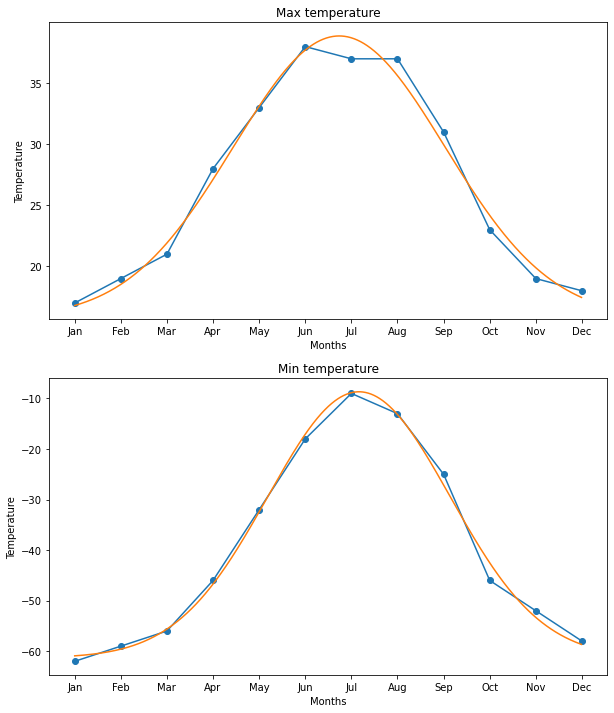

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

x = np.arange(0, 11, 0.01)

ax1.plot_date(months, temp_max, xdate=True, linestyle='solid')
ax2.plot_date(months, temp_min, xdate=True, linestyle='solid')

ax1.plot(x, gaussian(x, *params_max))
ax2.plot(x, gaussian(x, *params_min))

ax1.set_title('Max temperature')
ax1.set_xlabel('Months')
ax1.set_ylabel('Temperature')

ax2.set_title('Min temperature')
ax2.set_xlabel('Months')
ax2.set_ylabel('Temperature')

Results are reasonable from a visual point of view and from the analysis of the covariance matrix

The shift of time is not the same

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [8]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2021-12-08 17:53:06--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [following]
--2021-12-08 17:53:06--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc0ff21a9152b7ce6f8195f42c1.dl.dropboxusercontent.com/cd/0/inline/Bbc9pjgVIIytTlQKJC3ojKgtnh8vVqKdyAE8kXQ0-p3_hWXtr0amEZjMgDwFhQ6vJiir7Kt669mXVeM0PWTitV8X02_7DvERQS8hetLFZ0SpziT-IA3HRGlXXqUji-tufYoSW3A3UK0FF8U2P8TyrDMp/file# [following]
--2021-12-08 17:53:07--  https://ucc0ff21a9152b7ce6f8195f42c1.dl.dropboxusercontent.com/cd/0/inline/Bbc9pjgVIIytTlQKJC3ojKgtnh8vVqKdyAE8kXQ0-p3_hWXtr0amEZjMgDwFhQ6vJiir7Kt669mXVeM0PWTitV8X02_7DvERQS8he

In [90]:
import pickle
import pandas as pd
import numpy as np

filename = 'data/residuals_261.pkl'
pickle_file = pd.read_pickle(filename)

data = np.array(pickle_file, ndmin=1)[0]

df = pd.DataFrame(data, columns=['residuals', 'distances'])
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


Text(0, 0.5, 'Entries')

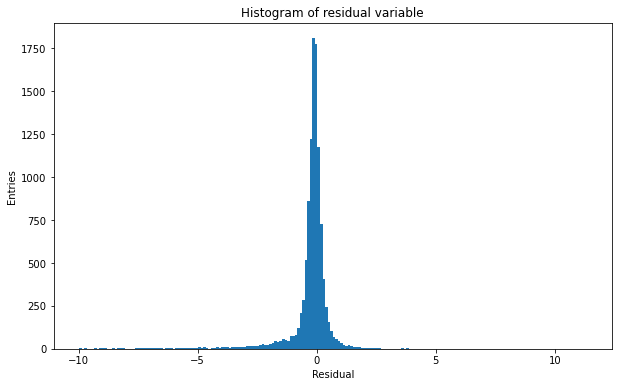

In [117]:
df = df[df['residuals'] > -10]

fig, ax = plt.subplots(figsize=(10, 6))
h, bins, _ = plt.hist(df['residuals'], bins=200)

ax.set_title('Histogram of residual variable')
ax.set_xlabel('Residual')
ax.set_ylabel('Entries')

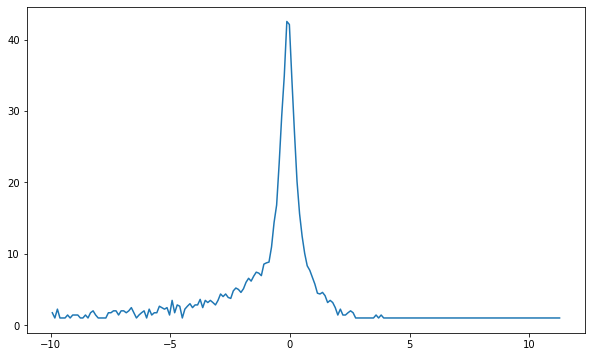

In [139]:
fig, ax = plt.subplots(figsize=(10, 6))

centers = 0.5 * (bins[:-1] + bins[1:])
h_err = np.sqrt(h)
h_err[h_err == 0] = 1 # Fix for NaN values 

ax.plot(centers, h_err)

In [140]:
def gaussian(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

params, params_covariance = optimize.curve_fit(gaussian, centers, h, full_output=False)

print('Parameters for max temp')
print('H = %.2f +- %.2f' % (params[0], np.sqrt(params_covariance[0,0])))
print('A = %.2f +- %.2f' % (params[1], np.sqrt(params_covariance[1,1])))
print('x0 = %.2f +- %.2f' % (params[2], np.sqrt(params_covariance[2,2])))
print('Sigma = %.2f +- %.2f\n' % (params[3], np.sqrt(params_covariance[3,3])))

Parameters for max temp
H = 9.88 +- 2.17
A = 1710.54 +- 18.97
x0 = -0.09 +- 0.00
Sigma = -0.22 +- 0.00



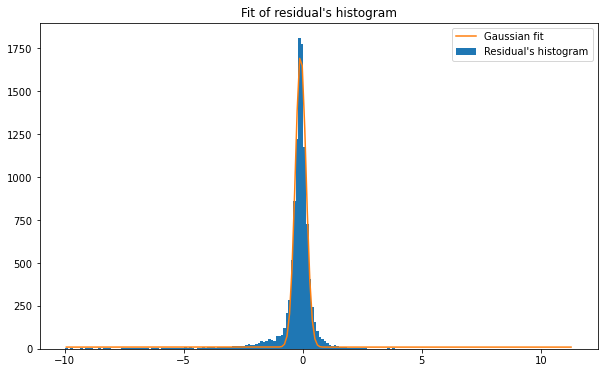

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(df['residuals'], bins=200, label='Residual\'s histogram')
plt.plot(centers, gaussian(centers, *params), label='Gaussian fit')

ax.set_title('Fit of residual\'s histogram')
ax.legend()

In [142]:
from scipy import stats

ndof = len(centers) - 1
print("n degrees of freedom =", ndof)
# calculate the chi^2
chi2 = np.sum(((h - gaussian(centers, *params))**2) / h_err)
print("chi2 =", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

n degrees of freedom = 199
chi2 = 20494.12201814765
p-value = 0.0


So the fit is not satisfactory

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [9]:
!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

--2021-12-08 17:53:08--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [following]
--2021-12-08 17:53:08--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38b428890e7a657a57e27879ca.dl.dropboxusercontent.com/cd/0/inline/BbcHhsv4Ijpr-QZOhP0Lj0O81srtOH3ixNMCQt9hcHNmQb7v_UzMHWRaWK-sC0DEMkd8c0wmt-3L1ulztPR18KCqzE-DlOaIhdYH70zf64DcYd7cPnTjGyQkPi-zskIgfNdXW29yru2M8lUP7FBYpUIH/file# [following]
--2021-12-08 17:53:08--  https://uc38b428890e7a657a57e27879ca.dl.dropboxusercontent.com/cd/0/inline/BbcHhsv4Ijpr-QZOh

In [56]:
import pandas as pd

df1 = pd.read_csv('data/munich_temperatures_average_with_bad_data.txt', sep=' ', names=['Time', 'Temp'], dtype={'Time': str})
df1[['Year', 'Day']] = df1['Time'].str.split('.', expand=True).astype(int)

df2 = df1[df1['Year'].between(2008, 2011, inclusive=True)]
df2 = df2[df2['Temp'] < 50]
df2

,Time,Temp,Year,Day
4748,2008.00274,-2.94444,2008,274
4749,2008.00548,-2.66667,2008,548
4750,2008.00821,-2.66667,2008,821
4751,2008.01095,-2.00000,2008,1095
4752,2008.01369,-1.94444,2008,1369
...,...,...,...,...
6204,2011.98836,3.44444,2011,98836
6205,2011.99110,1.27778,2011,99110
6206,2011.99384,2.88889,2011,99384
6207,2011.99658,1.83333,2011,99658


In [57]:
def f1(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c

def f2(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

In [67]:
dates = df2['Time'].to_numpy()
temps = df2['Temp'].to_numpy()

params1, params_covariance1 = optimize.curve_fit(f1, dates, temps)

print('Parameters')
print('a = %.2f +- %.2f' % (params1[0], np.sqrt(params_covariance1[0,0])))
print('b = %.2f +- %.2f' % (params1[1], np.sqrt(params_covariance1[1,1])))
print('c = %.2f +- %.2f\n' % (params1[2], np.sqrt(params_covariance1[2,2])))

params2, params_covariance2 = optimize.curve_fit(f2, dates, temps)

print('Parameters')
print('a = %.2f +- %.2f' % (params2[0], np.sqrt(params_covariance2[0,0])))
print('b = %.2f +- %.2f' % (params2[1], np.sqrt(params_covariance2[1,1])))
print('c = %.2f +- %.2f' % (params2[2], np.sqrt(params_covariance2[2,2])))
print('d = %.2f +- %.2f' % (params2[3], np.sqrt(params_covariance2[3,3])))

Parameters
a = -9.96 +- 0.13
b = 12.33 +- 0.01
c = 9.26 +- 0.09

Parameters
a = -9.96 +- 0.13
b = 1.00 +- 0.00
c = 8.62 +- 23.79
d = 9.27 +- 0.10


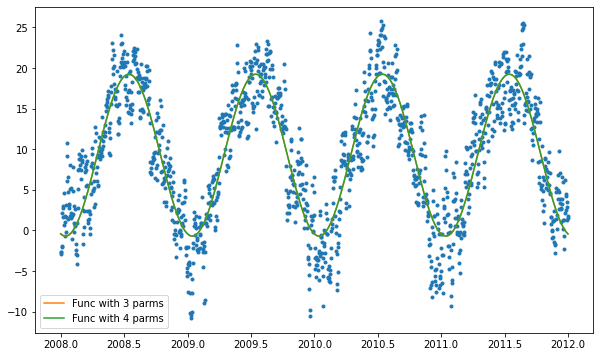

In [89]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(2008, 2012, len(temps))
y1 = f1(x, *params1)
y2 = f2(x, *params2)

ax.plot(x, temps, '.')
ax.plot(x, y1, label='Func with 3 parms')
ax.plot(x, y2, label='Func with 4 parms')
ax.legend()

In [75]:
from scipy.stats import f

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ssr_1 = np.sum((y1 - temps)**2)
ssr_2 = np.sum((y2 - temps)**2)

print("SSR:", ssr_1, ssr_2)

print("3-params vs 4-params:")
cl_1_vs_2 = Ftest(ssr_1, ssr_2, 2, 3, len(temps), verbose=True)

SSR: 18662.47749887979 18663.717422005517
3-params vs 4-params:
CL: 1.000 , additional parameter necessary: NO


So the function with only 3 parameters is able to approximate the data, with no need for an additional parameter.
So best-fit values of the parameters:
a = -9.96, b = 12.33, c = 9.26

In [77]:
temp_avg = df2['Temp'].mean()

print(f'Overall average temperature in Munich {temp_avg}')

Overall average temperature in Munich 9.261252084167236


In [85]:
temp_max_avg = df2.groupby('Year')['Temp'].max().mean()
temp_min_avg = df2.groupby('Year')['Temp'].min().mean()

print('The max average temperature is: ', temp_max_avg)
print('The min average temperature is: ', temp_min_avg)

The max average temperature is:  24.6389
The min average temperature is:  -8.625005


The b parameter (referring to the 3-params function) corresponds to the phase. So it shifts the same sinusoidal function in time.